In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from torch.utils.data import DataLoader
import xarray as xr

from src.datasets import WotusDataset, ConcatSatelliteDataset
from src.datamodules import WotusDataModule
from src.datasources import wotus_index, PS_BANDS, S2_BANDS13
from src.datautils import ToTensor2, Compose4d, PadCollate, ConcatPadCollate
from src.plot import show

---


# Mean and std

In [3]:
# from tqdm import tqdm

# df = wotus_index()
# df_planet = df.loc['planet']
# df_sentinel = df.loc['sentinel']

# band_means = []
# band_vars = []
# for path in df_planet['path']:
#     x = xr.open_rasterio(path)
#     m = x.mean(axis=(1, 2)).values
#     var = x.std(axis=(1, 2)).values
#     band_means.append(m)
#     band_vars.append(var)

# print(np.array(band_means).mean(axis=0))
# print(np.sqrt(np.array(band_vars).mean(axis=0)))

# band_means = []
# band_vars = []
# for path in tqdm(df_sentinel['path']):
#     x = xr.open_rasterio(path)
#     m = x.mean(axis=(1, 2)).values
#     var = x.var(axis=(1, 2)).values
#     band_means.append(m)
#     band_vars.append(std)

# print(np.array(band_means).mean(axis=0))
# print(np.sqrt(np.array(band_vars).mean(axis=0)))

---

# Datasets

In [4]:
wotus_index()

path  \
sat      scene        datetime                                                       
planet   ID_0         2019-10-11      /data/wotus/train/ID_0/images/2019-10-11.tif   
         ID_1         2019-09-25      /data/wotus/train/ID_1/images/2019-09-25.tif   
         ID_2         2019-10-14      /data/wotus/train/ID_2/images/2019-10-14.tif   
         SD_0         2018-06-05      /data/wotus/train/SD_0/images/2018-06-05.tif   
         SD_1         2018-06-08      /data/wotus/train/SD_1/images/2018-06-08.tif   
...                                                                            ...   
sentinel UCWest_Focus 2018-09-07  /data/wotus/train/UCWest_Focus/S2/2018-09-07.tif   
                      2018-09-12  /data/wotus/train/UCWest_Focus/S2/2018-09-12.tif   
                      2018-09-17  /data/wotus/train/UCWest_Focus/S2/2018-09-17.tif   
                      2018-09-22  /data/wotus/train/UCWest_Focus/S2/2018-09-22.tif   
                      2018-09-27  /data/wotus/train/UCWest_Focus/S2/2018-09-27.tif   

                                        basename  split  
sat      scene        datetime                           
planet   ID_0         2019-10-11  2019-10-11.tif   test  
         ID_1         2019-09-25  2019-09-25.tif  train  
         ID_2         2019-10-14  2019-10-14.tif  train  
         SD_0         2018-06-05  2018-06-05.tif  train  
         SD_1         2018-06-08  2018-06-08.tif  train  
...                                          ...    ...  
sentinel UCWest_Focus 2018-09-07  2018-09-07.tif   test  
                      2018-09-12  2018-09-12.tif   test  
                      2018-09-17  2018-09-17.tif   test  
                      2018-09-22  2018-09-22.tif   test  
                      2018-09-27  2018-09-27.tif   test  

[225 rows x 3 columns]

These datasets will sample `10000` random patches from the `test` pool of scenes between `Nov 2019` to `Jan 2020`.

In [5]:
date_range = pd.date_range(start=f"2018-08-30", end=f"2019-10-31")
ds_planet = WotusDataset(sat='planet', bands=PS_BANDS['true_color'], date_range=date_range,
                         samples=1_000, train_val_test='test', debug=True)
print(ds_planet)

split test
sat planet
start 2018-08-30, end 2019-10-31
scenes 1, samples 1000
labels False
window_size None
transform None
random_seed 1337
data_dir /data/wotus/train
band means [717.0, 674.0, 434.0]
band stds [325.0, 237.0, 187.0]


In [6]:
ds_sentinel = WotusDataset(sat='sentinel', bands=S2_BANDS13['true_color'], date_range=date_range,
                           samples=1_000, train_val_test='test', debug=True)
print(ds_sentinel)

split test
sat sentinel
start 2018-08-30, end 2019-10-31
scenes 1, samples 1000
labels False
window_size None
transform None
random_seed 1337
data_dir /data/wotus/train
band means [2197.0, 2191.0, 2308.0]
band stds [1152.0, 1037.0, 1052.0]


---

Getting an item with the `__getitem__` and an integer index.

In [7]:
item = ds_planet[0]
print(item)

scene ID_0
revisits 1
dates ['2019-10-11']
images (1, 3, 4338, 2770)
clouds (1, 1, 4338, 2770)
labels None
clearances [1.0]
band means [406.74, 369.9, 198.18]


In [8]:
scene = ds_sentinel.scenes[0]
item = ds_sentinel[scene]
print(item)

scene ID_0
revisits 1
dates ['2019-09-09']
images (1, 3, 1302, 831)
clouds (1, 1, 1302, 831)
labels None
clearances [0.46]
band means [4033.37, 3899.39, 4145.05]


---

The item `images` is an `xarray.DataArray`, with TIFF metadata.
(**Disclaimer**: depending on the Dataset transform.)

In [9]:
print(item['images'].crs)
print(item['images'].transform)

+init=epsg:32611
(10.0, 0.0, 594300.000000004, 0.0, -10.0, 4865324.9999999665)


---

## Synchronized gets

Using a `str` scene name with `__getitem__` guarantees that both dataset will get the same scene.

In [10]:
scene = list(set(ds_planet.scenes) & set(ds_sentinel.scenes))[0]

P = ds_planet[scene]
S = ds_sentinel[scene]

print(P['scene'] == S['scene'])
print(scene)

True
ID_0


---

## `show` images with minimal code

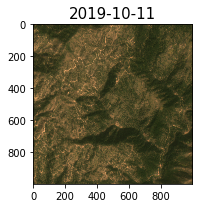

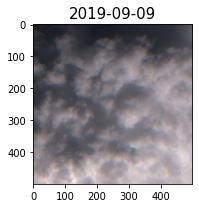

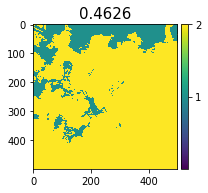

In [11]:
show(P['images'][:, :, :1000, :1000])

S_img = S['images'][:, :, :500, :500]
show(S_img)
show(S['clouds'][:, :, :500, :500], title=S['clearances'], colorbar=True)

---

# Windows

The `window_size` option set the height and width of window used to sample random patches. If we use the same `Dataset` type, `random_seed` **DOES** get the same scene.

('ID_0', (slice(3223, 4223, None), slice(189, 1189, None)))
('ID_0', (slice(3223, 3723, None), slice(189, 689, None)))


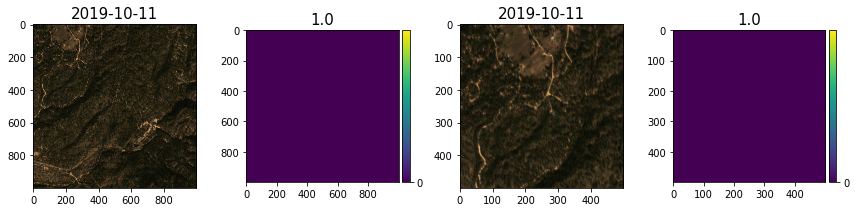

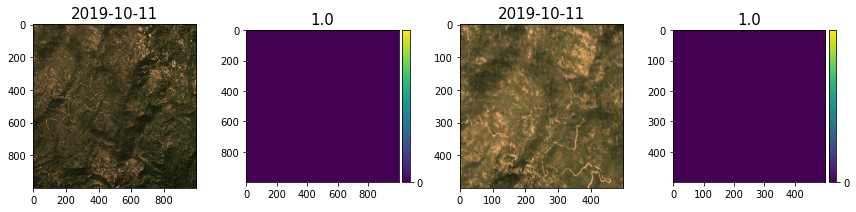

In [12]:
ds_planet = WotusDataset(sat='planet', bands=PS_BANDS['true_color'], date_range=date_range,
                         samples=10, train_val_test='test', window_size=1000, debug=True)
ds_planet_windowed = WotusDataset(sat='planet', bands=PS_BANDS['true_color'], date_range=date_range,
                                  samples=10, train_val_test='test', window_size=500, debug=True)

print(ds_planet.patches[0])
print(ds_planet_windowed.patches[0])

for i in range(2):
    x, m, c = (ds_planet[i][k] for k in ['images', 'clouds', 'clearances'])
    x2, m2, c2 = (ds_planet_windowed[i][k] for k in ['images', 'clouds', 'clearances'])
    show([x[0], m[0], x2[0], m2[0]], title=['', float(c[0]), '', float(c2[0])], colorbar=True)
#     x, m, c, l = (ds_planet[i][k] for k in ['images', 'clouds', 'clearances', 'labels'])
#     x2, m2, c2, l2 = (ds_planet_windowed[i][k] for k in ['images', 'clouds', 'clearances', 'labels'])
#     show([x[0], m[0], l[0], x2[0], m2[0], l2[0]], title=['', float(c[0]), '', '', float(c2[0]), ''], colorbar=True)

---
We can reset the dataset's `window_size`, which also resets `patches` using the same `random_seed`.

('ID_0', (slice(151, 451, None), slice(189, 489, None)))
('ID_0', (slice(151, 651, None), slice(189, 689, None)))


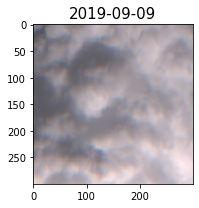

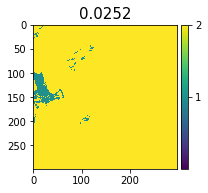

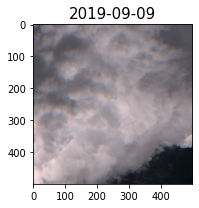

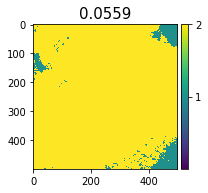

In [13]:
ds_sentinel = WotusDataset(sat='sentinel', bands=S2_BANDS13['true_color'], date_range=date_range,
                           samples=10, train_val_test='test', window_size=300, debug=True)
print(ds_sentinel.patches[0])
x, m, c = (ds_sentinel[0][k] for k in ['images', 'clouds', 'clearances'])

ds_sentinel.window_size = 500
print(ds_sentinel.patches[0])
x2, m2, c2 = (ds_sentinel[0][k] for k in ['images', 'clouds', 'clearances'])

show(x)
show(m, title=c, colorbar=True)
show(x2)
show(m2, title=c2, colorbar=True)


---

# Concatenated Dataset with windows

The synchronized gets are used under the hood of a custom ConcatDataset.

First we define the datasets to concatenate.

In [15]:
ds_planet = WotusDataset(sat='planet', bands=PS_BANDS['true_color'], date_range=date_range,
                         samples=10, train_val_test='test', debug=True)
ds_sentinel = WotusDataset(sat='sentinel', bands=S2_BANDS13['true_color'], date_range=date_range,
                           samples=10, train_val_test='test', debug=True)

concat_dataset_windowed = ConcatSatelliteDataset((ds_planet, ds_sentinel), window_size_planet=500)

scene ID_0
revisits 1
dates ['2019-10-11']
images (1, 3, 500, 500)
clouds (1, 1, 500, 500)
labels None
clearances [1.0]
band means [481.61, 409.19, 228.19] 

scene ID_0
revisits 1
dates ['2019-09-09']
images (1, 3, 150, 150)
clouds (1, 1, 150, 150)
labels None
clearances [1.0]
band means [898.58, 985.46, 1152.46]


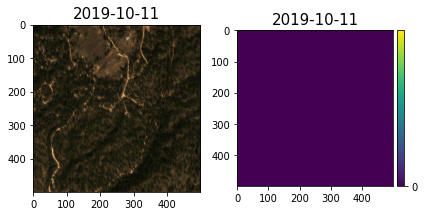

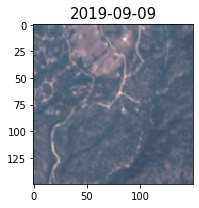

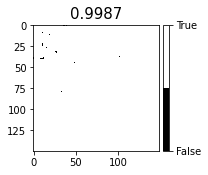

In [16]:
i = 0

item = concat_dataset_windowed[i]

hr, lr = item['highres'], item['lowres']
print(hr, '\n')
print(lr)

show([hr['images'], hr['clouds']], colorbar=True)
show(lr['images'])
show(ds_sentinel.clearance_masks(lr['clouds']), title=lr['clearances'], colorbar=True)

---

# Dataloaders

To use with `DataLoader`s, the items must be transformed to `Tensor`s.

In [17]:
dataset_sentinel = WotusDataset(sat='sentinel', bands=S2_BANDS13['true_color'], date_range=date_range, samples=20,
                                train_val_test='test', window_size=64, transform=Compose4d([ToTensor2()]), debug=True)

for i in range(5):
    print(f"{i} : {dataset_sentinel[i]['images'].shape}")

0 : torch.Size([1, 3, 64, 64])
1 : torch.Size([1, 3, 64, 64])
2 : torch.Size([1, 3, 64, 64])
3 : torch.Size([1, 3, 64, 64])
4 : torch.Size([1, 3, 64, 64])


Note how size of the Sentinel-2 tensors differ on the **revisits** dimension (and possibly in height / width).
We use `PadCollate` to zero-pad on time / height / width, as needed.

The original number of revisits is saved in `item['revisits']` for masking purposes.

In [18]:
dl = DataLoader(dataset_sentinel, batch_size=4, collate_fn=PadCollate())

print(f"Minibatches: {len(dl)}")
for i, x in enumerate(iter(dl)):
    print(f"{i*dl.batch_size}-{(i+1)*dl.batch_size - 1}: {list(x['images'].shape)}")

Minibatches: 5
0-3: [4, 1, 3, 64, 64]
4-7: [4, 1, 3, 64, 64]
8-11: [4, 1, 3, 64, 64]
12-15: [4, 1, 3, 64, 64]
16-19: [4, 1, 3, 64, 64]


---

**Same with Planet**

In [19]:
dataset_planet = WotusDataset(sat='planet', bands=PS_BANDS['true_color'], date_range=date_range, samples=100, window_size=100,
                              train_val_test='test', transform=Compose4d([ToTensor2()]), debug=True)

for i in range(5):
    print(f"{i} : {dataset_planet[i]['images'].shape}")

0 : torch.Size([1, 3, 100, 100])
1 : torch.Size([1, 3, 100, 100])
2 : torch.Size([1, 3, 100, 100])
3 : torch.Size([1, 3, 100, 100])
4 : torch.Size([1, 3, 100, 100])


In [20]:
dl = DataLoader(dataset_planet, batch_size=16, collate_fn=PadCollate())

print(f"Minibatches: {len(dl)}")
for i, x in enumerate(iter(dl)):
    print(f"{i*dl.batch_size}-{(i+1)*dl.batch_size - 1}: {list(x['images'].shape)}")

Minibatches: 7
0-15: [16, 1, 3, 100, 100]
16-31: [16, 1, 3, 100, 100]
32-47: [16, 1, 3, 100, 100]
48-63: [16, 1, 3, 100, 100]
64-79: [16, 1, 3, 100, 100]
80-95: [16, 1, 3, 100, 100]
96-111: [4, 1, 3, 100, 100]


---

## `DataLoader` for `ConcatDataset`


In [21]:
T = Compose4d([ToTensor2()])

ds_planet = WotusDataset(sat='planet', bands=PS_BANDS['true_color'], date_range=date_range, samples=20,
                         train_val_test='test', transform=T, debug=True)
ds_sentinel = WotusDataset(sat='sentinel', bands=S2_BANDS13['true_color'], date_range=date_range, samples=20,
                           train_val_test='test', transform=T, debug=True)

concat_dataset = ConcatSatelliteDataset((ds_planet, ds_sentinel), window_size_planet=500, force_size=150)

In [22]:
dl = DataLoader(concat_dataset, batch_size=4, collate_fn=ConcatPadCollate())

print(f"Minibatches: {len(dl)}")
for i, x in enumerate(iter(dl)):
    print(f"{i}: {list(x['highres']['images'].shape)}, {list(x['lowres']['images'].shape)}")

Minibatches: 5
0: [4, 1, 3, 500, 500], [4, 1, 3, 150, 150]
1: [4, 1, 3, 500, 500], [4, 1, 3, 150, 150]
2: [4, 1, 3, 500, 500], [4, 1, 3, 150, 150]
3: [4, 1, 3, 500, 500], [4, 1, 3, 150, 150]
4: [4, 1, 3, 500, 500], [4, 1, 3, 150, 150]


---

# DataModule

We use a custom `LightningDataModule` that encapsulates the `Dataset`, `DataLoader`, and `collate_fn`.

In [24]:
date_range = pd.date_range(start=f"2018-08-30", end=f"2019-10-31")
dm = WotusDataModule(date_range=date_range, s2_bands=S2_BANDS13['true_color'],
                     window_size_planet=150, samples=1_000, batch_size=32, debug=True)

dm.setup()

In [25]:
print(f"Minibatches: {len(dm.train_dataloader())}")
print(f"Train samples: {len(dm.train_dataloader().dataset)}")
print(f"Val samples: {len(dm.val_dataloader().dataset)}")
print(f"Test samples: {len(dm.val_dataloader().dataset)}")

dls = (dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader())
for dl, split in zip(dls, ('train', 'val', 'test')):
    print(f"\n{split}:")
    for i, x in enumerate(iter(dl)):
        print(f"{i*dm.batch_size}-{(i+1)*dm.batch_size-1}: "
              f"{list(x['highres']['images'].shape)} "
              f"{list(x['lowres']['images'].shape)}")

Minibatches: 25
Train samples: 800
Val samples: 100
Test samples: 100

train:
0-31: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
32-63: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
64-95: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
96-127: [32, 1, 4, 150, 150] [32, 1, 3, 46, 45]
128-159: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
160-191: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
192-223: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
224-255: [32, 1, 4, 150, 150] [32, 1, 3, 46, 45]
256-287: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
288-319: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
320-351: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
352-383: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
384-415: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
416-447: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
448-479: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
480-511: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
512-543: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
544-575: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]
576-607: [32, 1, 4, 150, 150] [32, 1, 3, 45, 45]

---

## A PlanetScope-only `DataModule`

In [26]:
date_range = pd.date_range(start=f"2018-08-30", end=f"2019-10-31")
dm = WotusDataModule(mode='planet', date_range=date_range, s2_bands=S2_BANDS13['true_color'],
                     window_size_planet=32, samples=2_000, batch_size=64, debug=True)

dm.setup()

In [27]:
print(f"Minibatches: {len(dm.train_dataloader())}")
print(f"Train samples: {len(dm.train_dataloader().dataset)}")
print(f"Val samples: {len(dm.val_dataloader().dataset)}")
print(f"Test samples: {len(dm.val_dataloader().dataset)}")

dls = (dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader())
for dl, split in zip(dls, ('train', 'val', 'test')):
    print(f"\n{split}:")
    for i, x in enumerate(iter(dl)):
        print(f"{i*dm.batch_size}-{(i+1)*dm.batch_size-1}: "
              f"{list(x['images'].shape)}")

Minibatches: 25
Train samples: 1600
Val samples: 200
Test samples: 200

train:
0-63: [64, 1, 4, 32, 32]
64-127: [64, 1, 4, 32, 32]
128-191: [64, 1, 4, 32, 32]
192-255: [64, 1, 4, 32, 32]
256-319: [64, 1, 4, 32, 32]
320-383: [64, 1, 4, 32, 32]
384-447: [64, 1, 4, 32, 32]
448-511: [64, 1, 4, 32, 32]
512-575: [64, 1, 4, 32, 32]
576-639: [64, 1, 4, 32, 32]
640-703: [64, 1, 4, 32, 32]
704-767: [64, 1, 4, 32, 32]
768-831: [64, 1, 4, 32, 32]
832-895: [64, 1, 4, 32, 32]
896-959: [64, 1, 4, 32, 32]
960-1023: [64, 1, 4, 32, 32]
1024-1087: [64, 1, 4, 32, 32]
1088-1151: [64, 1, 4, 32, 32]
1152-1215: [64, 1, 4, 32, 32]
1216-1279: [64, 1, 4, 32, 32]
1280-1343: [64, 1, 4, 32, 32]
1344-1407: [64, 1, 4, 32, 32]
1408-1471: [64, 1, 4, 32, 32]
1472-1535: [64, 1, 4, 32, 32]
1536-1599: [64, 1, 4, 32, 32]

val:
0-63: [64, 1, 4, 32, 32]
64-127: [64, 1, 4, 32, 32]
128-191: [64, 1, 4, 32, 32]
192-255: [8, 1, 4, 32, 32]

test:
0-63: [64, 1, 4, 32, 32]
64-127: [64, 1, 4, 32, 32]
128-191: [64, 1, 4, 32, 32]
192-25

---